In [324]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from Bio.Cluster import kcluster

In [119]:
"""
This is a user based Collaborative Filtering algorithm, using KMeans clustering to group users and find the most similar users to a given user, then make recommendations based on the most similar users' ratings.
"""
class UserBasedCFC:
    def __init__(self, filepath, k):
        self.filepath = filepath
        self.data = self.load_data(filepath)

    def load_data(self, filepath):
        print("加载数据...")
        rating = pd.read_csv(self.filepath)
        train_dict = rating.iloc[:,:3].to_dict('split')
        data = train_dict['data']
        return data

    def split_data(self):

"\nThis is a user based Collaborative Filtering algorithm, using KMeans clustering to group users and find the most similar users to a given user, then make recommendations based on the most similar users' ratings.\n"

In [278]:
filepath = 'ml-latest-small/ratings.csv'
ratings = pd.read_csv(filepath)
train_dict = ratings.iloc[:,:3].to_dict('split')
data = train_dict['data']

In [279]:
train_data = {}
test_data = {}
# control the random seed
np.random.seed(1)
for user, item, rating in data:
    if np.random.rand() < 0.8:
        if user not in train_data:
            train_data[user] = {}
        train_data[user][item] = rating
    else:
        if user not in test_data:
            test_data[user] = {}
        test_data[user][item] = rating

In [297]:
# read movie data and encoding movieId
movie = ratings['movieId'].drop_duplicates().to_frame()
movie.reset_index(inplace=True, drop=True)
movie.reset_index(inplace=True, drop=False)
movieId_dict = dict(zip(movie['movieId'], movie['index']))

In [298]:
# create a user-item matrix and fill it with ratings
user_item_matrix = np.zeros((len(train_data), len(movieId_dict)))
train_userIds = train_data.keys()
for i in train_data:
    for j in train_data[i]:
        user_item_matrix[list(train_userIds).index(i)][movieId_dict[j]] = train_data[i][j]

In [377]:
label, error, nfound = kcluster(user_item_matrix, nclusters=3, dist='k', npass=20)
# create a dict to store the cluster of each user
user_cluster = {}
for i in range(len(train_userIds)):
    user_cluster[list(train_userIds)[i]] = label[i]

KeyboardInterrupt: 

In [ ]:
silhouette_score(user_item_matrix, label)

In [371]:
# build the inverse table for item_users
item_users = dict()
for user, items in train_data.items():
    for item in items.keys():
        if item not in item_users:
            item_users[item] = set()
        item_users[item].add(user)
# calculate co-rated items between users
C = dict()
N = dict()
for item, users in item_users.items():
    for u in users:
        if u not in N:
            N[u] = 0
        N[u] += 1
        for v in users:
            if u == v:
                continue
            if u not in C:
                C[u] = {}
            if v not in C[u]:
                C[u][v] = 0
            # C[u][v] += 1
            C[u][v] += 1 / np.log(1 + len(users) * 1.0)
# calculate finial similarity matrix W
W = dict()
for u, related_users in C.items():
    if u not in W:
        W[u] = {}
    for v, cuv in related_users.items():
        W[u][v] = cuv / np.sqrt(N[u] * N[v])

In [372]:
# transfer user_cluster to cluster_user
cluster_user = {}
for user, cluster in user_cluster.items():
    if cluster not in cluster_user:
        cluster_user[cluster] = set()
    cluster_user[cluster].add(user)

In [373]:
rank = dict() # store the final recommendation result
k = 5
for user in train_data.keys():
    rank[user] = dict()
    interacted_items = train_data[user]
    cluster = user_cluster[user]
    same_cluster_users = list(cluster_user[cluster])
    user_sim_matrix_group = dict()

    for m in W[user]:
        if m in same_cluster_users:
            user_sim_matrix_group[m] = W[user][m]

    for v, wuv in sorted(user_sim_matrix_group.items(), key=lambda x: x[1], reverse=True)[0:k]:
        for i, rvi in train_data[v].items():
            if i in interacted_items:
                continue
            if i not in rank[user]:
                rank[user][i] = 0
            rank[user][i] += wuv * rvi

    max_score = max(rank[user].values())
    min_score = min(rank[user].values())
    for i in rank[user].keys():
        rank[user][i] = ((rank[user][i] - min_score) / (max_score - min_score)) * 5
recommendations = rank.copy()

ValueError: max() arg is an empty sequence

In [ ]:
hit = 0
all = 0
n = 10
for user in train_data.keys():
    tu = test_data[user]
    rank = recommendations[user]
    for item, pui in sorted(rank.items(), key=lambda x: x[1], reverse=True)[0:n]:
        if item in tu:
            hit += 1
    all += n
print("准确率为：%.4f" % (hit / (all * 1.0)))

In [340]:
# import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
from sklearn.cluster import KMeans
from Bio.Cluster import kcluster

In [357]:
# Define the class of traditional user based collaborative filtering
class UserBasedCFK:
    def __init__(self, filepath, k=10, n=10):
        self.filepath = filepath
        self.k = k
        self.n = n
        self.data = self.load_data()
        self.train_data, self.test_data = self.split_data()
        self.user_cluster, self.cluster_user = self.cluster_user()
        self.user_sim_matrix = self.user_similarity()
        self.recommendation = self.recommend()

    # load data
    def load_data(self):
        print("加载数据...")
        rating = pd.read_csv(self.filepath)
        train_dict = rating.iloc[:,:3].to_dict('split')
        data = train_dict['data']
        return data

    # split data
    def split_data(self):
        print("分割数据...")
        train_data = {}
        test_data = {}
        # control the random seed
        np.random.seed(1)
        for user, item, rating in self.data:
            if np.random.rand() < 0.8:
                if user not in train_data:
                    train_data[user] = {}
                train_data[user][item] = rating
            else:
                if user not in test_data:
                    test_data[user] = {}
                test_data[user][item] = rating
        return train_data, test_data

    def cluster_user(self):
        ratings = pd.read_csv(self.filepath)
        # read movie data and encoding movieId
        movie = ratings['movieId'].drop_duplicates().to_frame()
        movie.reset_index(inplace=True, drop=True)
        movie.reset_index(inplace=True, drop=False)
        movieId_dict = dict(zip(movie['movieId'], movie['index']))

        # create a user-item matrix and fill it with ratings
        user_item_matrix = np.zeros((len(self.train_data), len(movieId_dict)))
        train_userIds = self.train_data.keys()
        for i in self.train_data:
            for j in self.train_data[i]:
                user_item_matrix[list(train_userIds).index(i)][movieId_dict[j]] = self.train_data[i][j]

        label, error, nfound = kcluster(user_item_matrix, nclusters=3, dist='e', npass=20)
        # create a dict to store the cluster of each user
        user_cluster = {}
        for i in range(len(train_userIds)):
            user_cluster[list(train_userIds)[i]] = label[i]

        # transfer user_cluster to cluster_user
        cluster_user = {}
        for user, cluster in user_cluster.items():
            if cluster not in cluster_user:
                cluster_user[cluster] = set()
            cluster_user[cluster].add(user)

        return user_cluster, cluster_user


    def user_similarity(self):
        print("计算用户相似度矩阵...")
        # build the inverse table for item_users
        item_users = dict()
        for user, items in self.train_data.items():
            for item in items.keys():
                if item not in item_users:
                    item_users[item] = set()
                item_users[item].add(user)
        # calculate co-rated items between users
        C = dict()
        N = dict()
        for item, users in item_users.items():
            for u in users:
                if u not in N:
                    N[u] = 0
                N[u] += 1
                for v in users:
                    if u == v:
                        continue
                    if u not in C:
                        C[u] = {}
                    if v not in C[u]:
                        C[u][v] = 0
                    # C[u][v] += 1
                    C[u][v] += 1 / np.log(1 + len(users) * 1.0)
        # calculate finial similarity matrix W
        W = dict()
        for u, related_users in C.items():
            if u not in W:
                W[u] = {}
            for v, cuv in related_users.items():
                W[u][v] = cuv / np.sqrt(N[u] * N[v])
        return W

    # recommend items for each user
    def recommend(self):
        print("为每个用户推荐物品...")
        rank = dict()
        for user in self.train_data.keys():
            rank[user] = dict()
            interacted_items = self.train_data[user]
            cluster = self.user_cluster[user]
            same_cluster_users = list(self.cluster_user[cluster])
            user_sim_matrix_group = dict()

            for m in self.user_sim_matrix[user]:
                if m in same_cluster_users:
                    user_sim_matrix_group[m] = self.user_sim_matrix[user][m]

            for v, wuv in sorted(user_sim_matrix_group.items(), key=lambda x: x[1], reverse=True)[0:self.k]:
                for i, rvi in self.train_data[v].items():
                    if i in interacted_items:
                        continue
                    if i not in rank[user]:
                        rank[user][i] = 0
                    rank[user][i] += wuv * rvi

            max_score = max(rank[user].values())
            min_score = min(rank[user].values())
            for i in rank[user].keys():
                rank[user][i] = ((rank[user][i] - min_score) / (max_score - min_score)) * 5
        return rank

    # calculate the precision
    def precision(self):
        print("计算准确率...")
        hit = 0
        all = 0
        for user in self.train_data.keys():
            tu = self.test_data[user]
            rank = self.recommendation[user]
            for item, pui in sorted(rank.items(), key=lambda x: x[1], reverse=True)[0:self.n]:
                if item in tu:
                    hit += 1
            all += self.n
        print("准确率为：%.4f" % (hit / (all * 1.0)))
        return hit / (all * 1.0)

    # calculate the recall
    def recall(self):
        print("计算召回率...")
        hit = 0
        all = 0
        for user in self.train_data.keys():
            tu = self.test_data[user]
            rank = self.recommendation[user]
            for item, pui in sorted(rank.items(), key=lambda x: x[1], reverse=True)[0:self.n]:
                if item in tu:
                    hit += 1
            all += len(tu)
        print("召回率为：%.4f" % (hit / (all * 1.0)))
        return hit / (all * 1.0)

    # calculate the mae
    def mae(self):
        print("计算平均绝对误差...")
        mae = 0
        cnt = 0
        for user in self.train_data.keys():
            tu = self.test_data[user]
            rank = self.recommendation[user]
            for item, pui in sorted(rank.items(), key=lambda x: x[1], reverse=True)[0:self.n]:
                if item in tu:
                    mae += abs(pui - tu[item])
                    cnt += 1
        print("平均绝对误差为：%.4f" % (mae / cnt))
        return mae / cnt

In [358]:
# Define the class of traditional user based collaborative filtering
class UserBasedCF:
    def __init__(self, filepath, k=10, n=10):
        self.filepath = filepath
        self.k = k
        self.n = n
        self.data = self.load_data()
        self.train_data, self.test_data = self.split_data()
        self.user_sim_matrix = self.user_similarity()
        self.recommendation = self.recommend()

    # load data
    def load_data(self):
        print("加载数据...")
        rating = pd.read_csv(self.filepath)
        train_dict = rating.iloc[:,:3].to_dict('split')
        data = train_dict['data']
        return data

    # split data
    def split_data(self):
        print("分割数据...")
        train_data = {}
        test_data = {}
        # control the random seed
        np.random.seed(1)
        for user, item, rating in self.data:
            if np.random.rand() < 0.8:
                if user not in train_data:
                    train_data[user] = {}
                train_data[user][item] = rating
            else:
                if user not in test_data:
                    test_data[user] = {}
                test_data[user][item] = rating
        return train_data, test_data

    # calculate the similarity between users with cosine similarity using train data
    def user_similarity(self):
        print("计算用户相似度矩阵...")
        # build the inverse table for item_users
        item_users = dict()
        for user, items in self.train_data.items():
            for item in items.keys():
                if item not in item_users:
                    item_users[item] = set()
                item_users[item].add(user)
        # calculate co-rated items between users
        C = dict()
        N = dict()
        for item, users in item_users.items():
            for u in users:
                if u not in N:
                    N[u] = 0
                N[u] += 1
                for v in users:
                    if u == v:
                        continue
                    if u not in C:
                        C[u] = {}
                    if v not in C[u]:
                        C[u][v] = 0
                    C[u][v] += 1
        # calculate finial similarity matrix W
        W = dict()
        for u, related_users in C.items():
            if u not in W:
                W[u] = {}
            for v, cuv in related_users.items():
                W[u][v] = cuv / np.sqrt(N[u] * N[v])
        return W

    # recommend items for each user
    def recommend(self):
        print("为每个用户推荐物品...")
        rank = dict()
        cnt = dict()
        for user in self.train_data.keys():
            rank[user] = dict()
            interacted_items = self.train_data[user]
            for v, wuv in sorted(self.user_sim_matrix[user].items(), key=lambda x: x[1], reverse=True)[0:self.k]:
                for i, rvi in self.train_data[v].items():
                    if i in interacted_items:
                        continue
                    if i not in rank[user]:
                        rank[user][i] = 0
                    rank[user][i] += wuv * rvi
            max_score = max(rank[user].values())
            min_score = min(rank[user].values())
            for i in rank[user].keys():
                rank[user][i] = ((rank[user][i] - min_score) / (max_score - min_score)) * 5
        return rank

    # calculate the precision
    def precision(self):
        print("计算准确率...")
        hit = 0
        all = 0
        for user in self.train_data.keys():
            tu = self.test_data[user]
            rank = self.recommendation[user]
            for item, pui in sorted(rank.items(), key=lambda x: x[1], reverse=True)[0:self.n]:
                if item in tu:
                    hit += 1
            all += self.n
        print("准确率为：%.4f" % (hit / (all * 1.0)))
        return hit / (all * 1.0)

    # calculate the recall
    def recall(self):
        print("计算召回率...")
        hit = 0
        all = 0
        for user in self.train_data.keys():
            tu = self.test_data[user]
            rank = self.recommendation[user]
            for item, pui in sorted(rank.items(), key=lambda x: x[1], reverse=True)[0:self.n]:
                if item in tu:
                    hit += 1
            all += len(tu)
        print("召回率为：%.4f" % (hit / (all * 1.0)))
        return hit / (all * 1.0)

    # calculate the mae
    def mae(self):
        print("计算平均绝对误差...")
        mae = 0
        cnt = 0
        for user in self.train_data.keys():
            tu = self.test_data[user]
            rank = self.recommendation[user]
            for item, pui in sorted(rank.items(), key=lambda x: x[1], reverse=True)[0:self.n]:
                if item in tu:
                    mae += abs(pui - tu[item])
                    cnt += 1
        print("平均绝对误差为：%.4f" % (mae / cnt))
        return mae / cnt

In [359]:
# calculate the precision, recall, mse for different k value, n = 10
k_list = [5, 10, 15, 20, 25, 30, 40, 50]
precision_list = []
recall_list = []
mae_list = []
precision_list_2 = []
recall_list_2 = []
mae_list_2 = []
for k in k_list:
    ubf_k = UserBasedCFK(filepath='ml-latest-small/ratings.csv', k=k)
    precision_list.append(ubf_k.precision())
    recall_list.append(ubf_k.recall())
    mae_list.append(ubf_k.mae())

    ubf = UserBasedCF(filepath='ml-latest-small/ratings.csv', k=k)
    precision_list_2.append(ubf.precision())
    recall_list_2.append(ubf.recall())
    mae_list_2.append(ubf.mae())


加载数据...
分割数据...
计算用户相似度矩阵...
为每个用户推荐物品...
计算准确率...
准确率为：0.2293
计算召回率...
召回率为：0.0694
计算平均绝对误差...
平均绝对误差为：0.9166
加载数据...
分割数据...
计算用户相似度矩阵...
为每个用户推荐物品...
计算准确率...
准确率为：0.2318
计算召回率...
召回率为：0.0701
计算平均绝对误差...
平均绝对误差为：0.8867
加载数据...
分割数据...
计算用户相似度矩阵...
为每个用户推荐物品...
计算准确率...
准确率为：0.2505
计算召回率...
召回率为：0.0758
计算平均绝对误差...
平均绝对误差为：0.8219
加载数据...
分割数据...
计算用户相似度矩阵...
为每个用户推荐物品...
计算准确率...
准确率为：0.2531
计算召回率...
召回率为：0.0766
计算平均绝对误差...
平均绝对误差为：0.8335
加载数据...
分割数据...
计算用户相似度矩阵...
为每个用户推荐物品...
计算准确率...
准确率为：0.2557
计算召回率...
召回率为：0.0774
计算平均绝对误差...
平均绝对误差为：0.8505
加载数据...
分割数据...
计算用户相似度矩阵...
为每个用户推荐物品...
计算准确率...
准确率为：0.2608
计算召回率...
召回率为：0.0789
计算平均绝对误差...
平均绝对误差为：0.8022
加载数据...
分割数据...
计算用户相似度矩阵...
为每个用户推荐物品...
计算准确率...
准确率为：0.2587
计算召回率...
召回率为：0.0783
计算平均绝对误差...
平均绝对误差为：0.8022
加载数据...
分割数据...
计算用户相似度矩阵...
为每个用户推荐物品...
计算准确率...
准确率为：0.2692
计算召回率...
召回率为：0.0814
计算平均绝对误差...
平均绝对误差为：0.7756
加载数据...
分割数据...
计算用户相似度矩阵...
为每个用户推荐物品...
计算准确率...
准确率为：0.2675
计算召回率...
召回率为：0.0810
计算平均绝对误差...
平均绝对误差为：0.8302
加

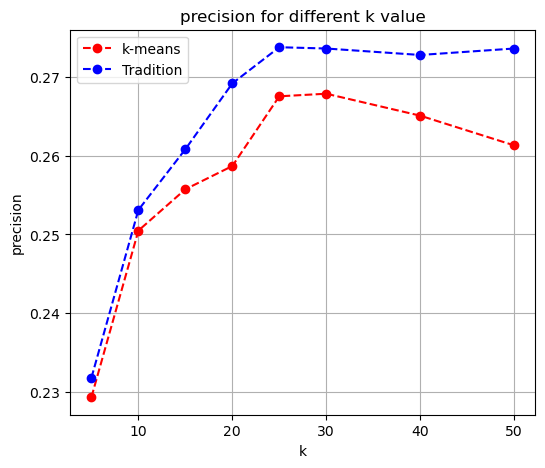

In [360]:
# create graph for precision
plt.figure(figsize=(6, 5))
plt.plot(k_list, precision_list, label='k-means', marker='o', color='r', linestyle='--')
plt.plot(k_list, precision_list_2, label='Tradition', marker='o', color='b', linestyle='--')
plt.grid(True)
plt.xlabel('k')
plt.ylabel('precision')
plt.title('precision for different k value')
plt.legend()
plt.show()

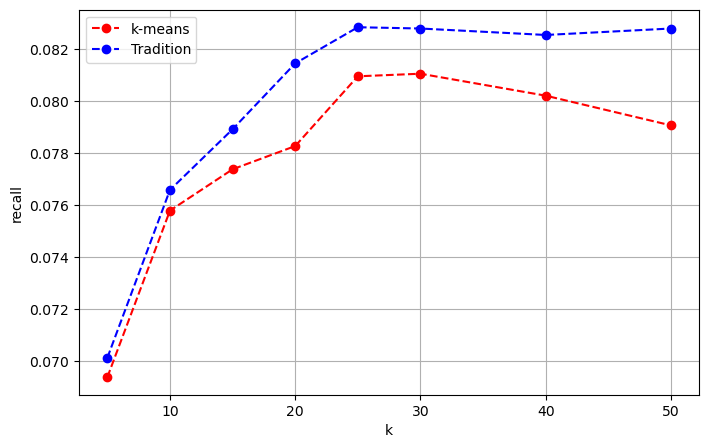

In [361]:
# create graphs for recall
plt.figure(figsize=(8, 5))
plt.plot(k_list, recall_list, label='k-means', marker='o', color='r', linestyle='--')
plt.plot(k_list, recall_list_2, label='Tradition', marker='o', color='b', linestyle='--')
plt.grid(True)
plt.xlabel('k')
plt.ylabel('recall')
plt.legend()
plt.show()

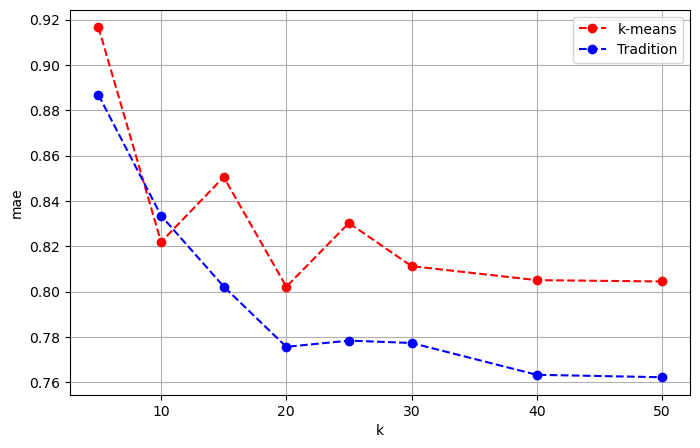

In [362]:
# create graph for mae
plt.figure(figsize=(8, 5))
plt.plot(k_list, mae_list, label='k-means', marker='o', color='r', linestyle='--')
plt.plot(k_list, mae_list_2, label='Tradition', marker='o', color='b', linestyle='--')
plt.grid(True)
plt.xlabel('k')
plt.ylabel('mae')
plt.legend()
plt.show()